#### Library Manager

In [2]:
import os
import IPython
import time 

import librosa
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from scipy.io.wavfile import read
from scipy import signal
import sounddevice as sd


#### Load Raw Audio

In [3]:
datafolder = './Data'
cliplen = 10
samplerate = 11025
hop_size = 512

Tx = 216
n_freq = 96
Ty = 105

piano = []
for i in range(10):
    piano.append(AudioSegment.from_wav(os.path.join(datafolder, 'positive', str(i)+'.wav')).set_channels(1).set_frame_rate(samplerate))
piano.append(AudioSegment.from_mp3(os.path.join(datafolder, 'positive', '11.mp3')).set_channels(1).set_frame_rate(samplerate))
piano.append(AudioSegment.from_mp3(os.path.join(datafolder, 'positive', '12.mp3')).set_channels(1).set_frame_rate(samplerate))
    
theatre = AudioSegment.from_mp3(os.path.join(datafolder, 'negative', 'theatre.mp3')).set_channels(1).set_frame_rate(samplerate)
coffee = AudioSegment.from_mp3(os.path.join(datafolder, 'negative', 'coffee.mp3')).set_channels(1).set_frame_rate(samplerate)
city = AudioSegment.from_mp3(os.path.join(datafolder, 'negative', 'city.mp3')).set_channels(1).set_frame_rate(samplerate)
guitar = AudioSegment.from_mp3(os.path.join(datafolder, 'negative', 'guitar.mp3')).set_channels(1).set_frame_rate(samplerate)
violin = AudioSegment.from_mp3(os.path.join(datafolder, 'negative', 'violin.mp3')).set_channels(1).set_frame_rate(samplerate)
opera = AudioSegment.from_mp3(os.path.join(datafolder, 'negative', 'opera.mp3')).set_channels(1).set_frame_rate(samplerate)

library = AudioSegment.from_mp3(os.path.join(datafolder, 'background', 'library.mp3')).set_channels(1).set_frame_rate(samplerate)
noise = AudioSegment.from_mp3(os.path.join(datafolder, 'background', 'whitenoise.mp3')).set_channels(1).set_frame_rate(samplerate)


#### Helper Functions

In [5]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

def insert_ones(y, segment_start_ms, segment_end_ms):   
    segment_start_y = int(segment_start_ms * Ty / 10000.0)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    shift=2
    for i in range(segment_start_y + shift, segment_end_y + 2*shift):
        if i < Ty:
            y[0, i] = 1
    
    return y

def is_overlapping(segment_time, previous_segments):   
    segment_start, segment_end = segment_time
    overlap = False
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

def get_random_time_segment(segment_ms, total_ms=10000):
    segment_start = np.random.randint(low=0, high=total_ms-segment_ms)  
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

def get_features(file):
    wf = read(file)
    wav = wf[1].astype(dtype='float32')
    features = librosa.feature.chroma_stft(y=wav,sr=samplerate, hop_length=hop_size,n_chroma=8*12)
    return features
    
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    segment_time = get_random_time_segment(segment_ms)
    ctr = 0
    while is_overlapping(segment_time, previous_segments) and ctr<100:
        segment_time = get_random_time_segment(segment_ms)
        ctr+=1
    
    if ctr==100:
        #previous_segments.append(segment_time)
        new_background = background
        segment_time = []
    else:
        previous_segments.append(segment_time)
        new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

def create_training_example(num_samples, Background, positives, negatives, datafolder='./Data'):
    """
    Creates a training example with a given background, positives, and negatives.
    
    Arguments:
    background -- background audio recording
    positives -- a list of audio segments of piano
    negatives -- a list of audio segments of random sounds that are not piano
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    Y = np.zeros((num_samples, Ty))
    X = np.zeros((num_samples, n_freq, Tx))
    
    for b in Background:
        b = match_target_amplitude(b, -20.0)
    for p in positives:
        p = match_target_amplitude(p, -20.0)
    for n in negatives:
        n = match_target_amplitude(n, -20.0)

        
    for i in range(num_samples):
        previous_segments = []
        y = np.zeros((1, Ty))

        # Pick a random background and make it quiter
        bix = np.random.randint(len(Background))
        sp = np.random.randint(len(Background[bix])-cliplen*1000)
        background = Background[bix][sp:sp+1000*cliplen]
        background = background - 20 - np.random.randint(20)
        
        # Select 0-2 random "activate" audio clips from the entire list of "positives" recordings
        number_of_positives = np.random.randint(1, 4)
        random_indices = np.random.randint(len(positives), size=number_of_positives)
        random_positives = [positives[i] for i in random_indices]
        
        # Loop over randomly selected "positives" clips and insert in background
        for random_positive in random_positives:
            audiolen = int((0.25+3*np.random.rand())*1000)
            sp = np.random.randint(len(random_positive)-audiolen)
            volume_adj = np.random.randint(10)
            audio_clip = random_positive[sp:sp+audiolen]-volume_adj
            background, segment_time = insert_audio_clip(background, audio_clip, previous_segments)
            if segment_time:
                segment_start, segment_end = segment_time
                y = insert_ones(y, segment_start_ms=segment_start, segment_end_ms=segment_end)
            else:
                print('not found')
                
        # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
        number_of_negatives = np.random.randint(0, 3)
        random_indices = np.random.randint(len(negatives), size=number_of_negatives)
        random_negatives = [negatives[i] for i in random_indices]

        # Loop over randomly selected negative clips and insert in background
        for random_negative in random_negatives:
            audiolen = int((0.25+2*np.random.rand())*1000)
            sp = np.random.randint(len(random_negative)-audiolen)
            volume_adj = np.random.randint(10)
            audio_clip = random_negative[sp:sp+audiolen]-volume_adj  
            background, _ = insert_audio_clip(background, audio_clip, previous_segments)

        # Standardize the volume of the audio clip 
        background = match_target_amplitude(background, -20.0)

        # Export new training example 
        filename = os.path.join(datafolder, 'clips', str(i) + ".wav")
        file_handle = background.export(filename, format="wav")

        # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
        x = get_features(filename)
        X[i,:,:] = x
        Y[i,:] = y
    
    np.savez('traindata.npz', X=X, Y=Y)
    return X, Y



#### Create Training Data

In [6]:
background = [library, noise]
negatives = [city, theatre, coffee, opera, violin, guitar]
positives = piano
num_samples = 512

X,Y = create_training_example(num_samples,background, positives, negatives)


not found
not found


C:\Users\niki\Anaconda3\envs\AudioProcess\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


not found
not found
not found
not found
not found
not found
not found
not found


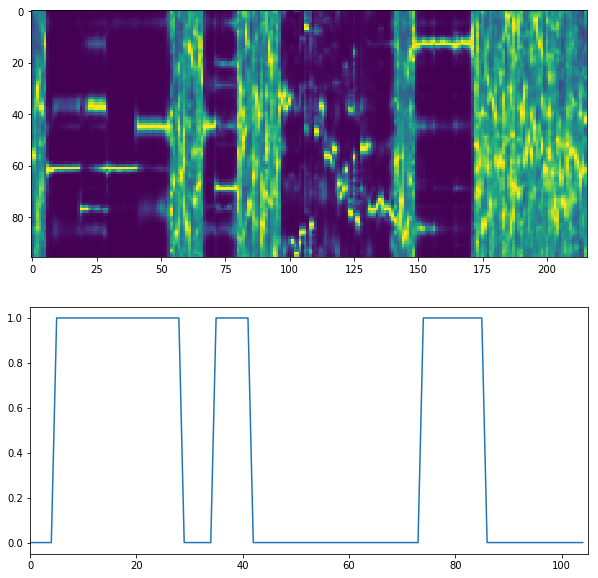

In [10]:
ix = 12

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.imshow(X[ix,:,:])
ax = fig.add_subplot(212)
ax.plot(Y[ix,:])
ax.set_xlim([0,Y.shape[1]])

IPython.display.Audio(os.path.join(datafolder, 'clips', str(ix)+'.wav'))

#### Define Model

In [11]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, LeakyReLU
from keras.optimizers import Adam

def detector(input_shape, n_conv=98, n_gru=64):
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer - reducing dimension
    X = Conv1D(n_conv, kernel_size=7, strides=2)(X_input)      # CONV1D 15/4
    X = BatchNormalization()(X)                                 
    X = LeakyReLU(alpha=0.1)(X)                                 
    X = Dropout(0.8)(X)                                 

    # Step 2: First GRU Layer - Time-series model
    X = GRU(units = n_gru, return_sequences = True)(X) 
    X = Dropout(0.8)(X)                                 
    X = BatchNormalization()(X)                         
    
    # Step 3: Second GRU Layer - Time-series model
    X = GRU(units = n_gru, return_sequences = True)(X)  
    X = Dropout(0.8)(X)                                 
    X = BatchNormalization()(X)                         
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

C:\Users\niki\Anaconda3\envs\AudioProcess\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [45]:
#model = detector(input_shape = (Tx, n_freq), n_conv = 192, n_gru = 128)
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

# Load Pre-trained weights
#model = load_model('model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 216, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 105, 192)          129216    
_________________________________________________________________
batch_normalization_4 (Batch (None, 105, 192)          768       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 105, 192)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 105, 192)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 105, 128)          123264    
_________________________________________________________________
dropout_5 (Dropout)          (None, 105, 128)          0         
__________

In [58]:
Xtrain = X.swapaxes(1,2)
Ytrain = Y[:,:,np.newaxis]

model.fit(Xtrain, Ytrain, validation_split=0.1, batch_size = 32, epochs=50)

Train on 460 samples, validate on 52 samples
Epoch 1/50
460/460 [==============================] - 5s 12ms/step - loss: 0.1432 - acc: 0.9543 - val_loss: 0.3178 - val_acc: 0.9238
Epoch 2/50
460/460 [==============================] - 5s 11ms/step - loss: 0.1446 - acc: 0.9538 - val_loss: 0.3168 - val_acc: 0.9253
Epoch 3/50
460/460 [==============================] - 5s 11ms/step - loss: 0.1423 - acc: 0.9543 - val_loss: 0.3193 - val_acc: 0.9225
Epoch 4/50
460/460 [==============================] - 5s 11ms/step - loss: 0.1460 - acc: 0.9533 - val_loss: 0.3194 - val_acc: 0.9253
Epoch 5/50
460/460 [==============================] - 5s 11ms/step - loss: 0.1383 - acc: 0.9565 - val_loss: 0.3213 - val_acc: 0.9236
Epoch 6/50
460/460 [==============================] - 5s 11ms/step - loss: 0.1412 - acc: 0.9552 - val_loss: 0.3223 - val_acc: 0.9223
Epoch 7/50
460/460 [==============================] - 5s 11ms/step - loss: 0.1406 - acc: 0.9543 - val_loss: 0.3193 - val_acc: 0.9240
Epoch 8/50
460/460 [====

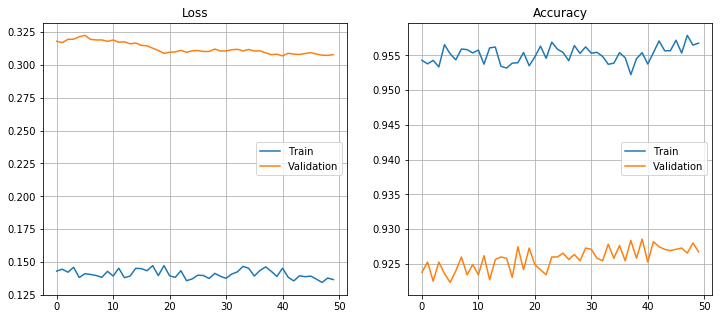

In [59]:
model.save('model.h5')

fig, ax = plt.subplots(1,2)
fig.set_size_inches((12,5))
ax[0].plot(model.history.history['loss'], label = 'Train')
ax[0].plot(model.history.history['val_loss'], label = 'Validation')
ax[0].grid()
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(model.history.history['acc'], label = 'Train')
ax[1].plot(model.history.history['val_acc'], label = 'Validation')
ax[1].grid()
ax[1].set_title('Accuracy')
ax[1].legend()

### Test Model

##### Setup Mic

In [17]:
buffer = np.zeros((0,1), dtype='float32')
framesinbuffer = samplerate*cliplen

def callback(indata, frames, time, status):  
    global buffer
    buffer = np.append(buffer, indata)
    if buffer.shape[0]>framesinbuffer:
        buffer = buffer[-framesinbuffer:]
        
mic = sd.InputStream(channels=1, 
                     callback=callback,
                     samplerate=samplerate)      

mic.start()
#sd.play(buffer, samplerate)

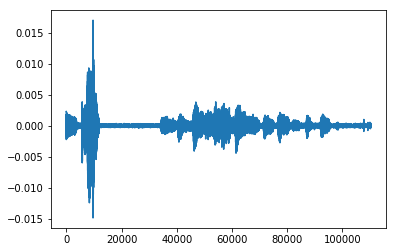

In [51]:
# Wait for 10 seconds
plt.plot(buffer)


#### Rolling Spectrogram + Piano Detection

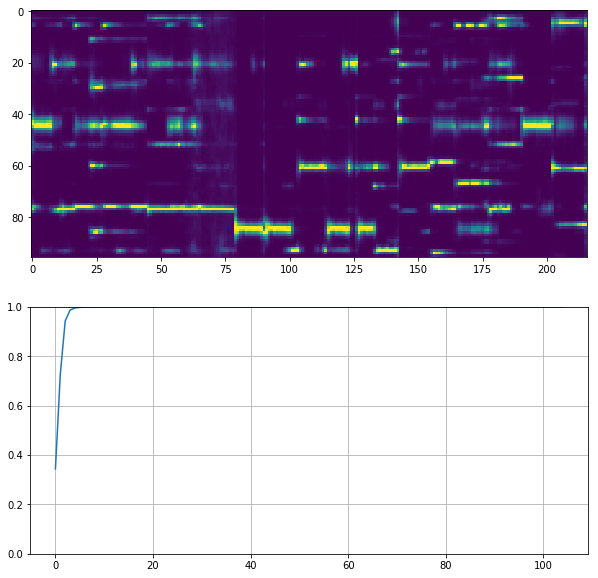

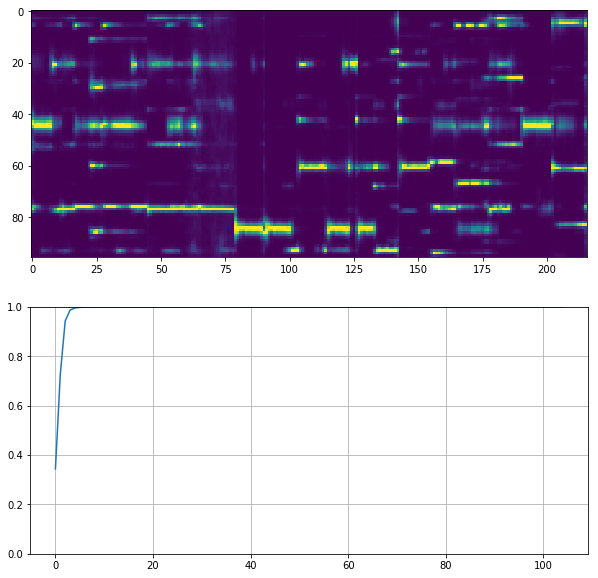

In [61]:
plt.ion()
mic.start()
#%matplotlib notebook
#%matplotlib tk
%matplotlib inline
#model = load_model('model.h5')


features = librosa.feature.chroma_stft(y=buffer,sr=samplerate, hop_length=hop_size,n_chroma=96)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
im = ax1.imshow(features)
ax2 = fig.add_subplot(212)
lines = ax2.plot(np.zeros((Ty,)))
ax2.set_ylim([0,1])
ax2.grid()

def update_plot(*args):
    global buffer
    
    features = librosa.feature.chroma_stft(y=buffer,sr=samplerate, hop_length=hop_size,n_chroma=96)   
    im.set_array(features)
    pred = model.predict(features[np.newaxis,:,:].swapaxes(1,2))
    lines[0].set_ydata(pred.squeeze())
    return [im,lines]
    
for i in range(100):
    time.sleep(0.01)
    update_plot()
    clear_output(wait=True)
    display(fig)
    
#ani = FuncAnimation(fig, update_plot, interval=50, blit=True)
#rc('animation', html='html5')
#ani

mic.stop()